In [3]:
import os
import numpy as np
from os import path
import pandas as pd
from itertools import combinations
import pylab as pl
import time 
from sklearn.preprocessing import PolynomialFeatures


#Funcion de distancia 1/4

In [4]:
VARIABLES = [
    "ozone",
    "radiation",
    "wind",
    "temperature"
]

In [5]:
paths = [
    "Resultados",
    "Data",
    "images"
]
def crearPaths(paths=paths):
    for p in paths:    
        if not path.exists(f"{os.getcwd()}/{p}"):
            os.mkdir(f"{os.getcwd()}/{p}")
crearPaths()




In [6]:
#Separo el dataset en los x y

df_data = pd.read_csv("./dataset.csv", index_col="index")
ozono = df_data["ozone"]
df_vars = df_data.drop("ozone", axis=1)

df_vars.to_csv("Data/variables.csv")
ozono.to_csv("Data/ozono.csv")
df_vars.head()

,X,radiation,temperature,wind
index,,,,
1,1,190,67,7.4
2,2,118,72,8.0
3,3,149,74,12.6
4,4,313,62,11.5
5,5,299,65,8.6


In [7]:
#le aplica la tricubica a un array
def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y

In [8]:
def estandarizar(variable):
	esperanza = np.mean(variable)
	var = np.var(variable)
	return (variable - esperanza)/var

def desestandarizar(variable, valor):
	esperanza = np.mean(variable)
	var = np.var(variable)
	return valor*var + esperanza

#Para que es 'valor'?

In [9]:
def euclideanDistances(punto, array_de_puntos):
    results = []
    for punto_del_array in array_de_puntos:
        diferencia =  punto_del_array - punto
        distancia = np.linalg.norm(diferencia)
        results.append(distancia) 
    return np.array(results)


In [64]:

class Loess(object):

    @staticmethod
    def normalize_array(array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    
    def normalize_matrix(self, matrix):
        return np.array(list(map(self.normalize_array, matrix)), dtype=object).transpose()

    def __init__(self, xx, yy, degree=1):
        self.n_vars_xx, self.array_mins_xx, self.array_maxs_xx = self.normalize_matrix(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

        self.n_vars_xx = np.array(list(self.n_vars_xx)).transpose()
        # print(self.n_vars_xx)
        # print(self.array_mins_xx)
        # print(self.array_maxs_xx)

    @staticmethod
    def get_min_idx_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
            
        if min_idx == n-1:
            return np.arange(n - window, n)
            
        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        
        return np.array(min_range)
    

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return np.array(weights)

    def normalize_x(self, array_of_values):
        return (array_of_values - self.array_mins_xx) / (self.array_maxs_xx - self.array_mins_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, degree=1):
        n_x = self.normalize_x(x)
        distances = euclideanDistances(n_x, self.n_vars_xx)
        min_idx_range = self.get_min_idx_range(distances, window )
        weights = self.get_weights(distances, min_idx_range)
        wm = np.multiply(np.eye(window), weights)
        
        poly = PolynomialFeatures(degree)
        xp = n_x.reshape(1,-1)
        xp = poly.fit_transform(xp)

        xm = self.n_vars_xx[min_idx_range]
        xm = poly.fit_transform(xm)

        ym = np.array(list(self.n_yy[min_idx_range]))
        # print(ym)
        
        xmt = np.transpose(xm)
        xmt_wm = xmt @ wm
        # print(xmt_wm)
        
        beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
        # print(beta)
    
        y = (beta @ xp.transpose())

        return self.denormalize_y(y)


def main():
    xx = np.genfromtxt("Data/variables.csv", delimiter=",", skip_header=1, usecols=(2,3,4))
    yy = np.genfromtxt("Data/ozono.csv", delimiter=",", skip_header=1, usecols=(1))
    
    
    xx = np.array(list(map(estandarizar, xx.transpose()))) #lo trasponemos una sola vez
    
    est_y = estandarizar(yy) 
    loess = Loess(xx, est_y)  
    print("Original: ", yy[0])
    predicciones = []
    for x in xx.transpose():
        y = loess.estimate(x, window=44, degree=1)
        print(float(desestandarizar(yy, y)))
        break
        predicciones.append(float(desestandarizar(yy, y)))
        
    df_resultado = pd.DataFrame(predicciones, columns=["predicciones"])
    df_resultado.to_csv("./Resultados/predicciones_base.csv")
    

if __name__ == "__main__":
    start = time.time()

    main()

    end = time. time()
    #print(end - start)
    #print(end - start)

Original:  41.0
38.39957635549341


In [79]:
def estimarLoess(variablesEntrada, useColsEntrada, variableSalida, archivoSalida, f, grado):
    xx = np.genfromtxt(variablesEntrada, delimiter=",", skip_header=1, usecols=useColsEntrada)
    yy = np.genfromtxt(variableSalida, delimiter=",", skip_header=1, usecols=(1))


    num_variables = 1
    if isinstance(useColsEntrada,int):
        xx = np.array([xx])
    else: 
        num_variables = len(useColsEntrada)
    
    xx = np.array(list(map(estandarizar, xx.transpose()))) #lo trasponemos una sola vez
    
    est_y = estandarizar(yy) 
    loess = Loess(xx, est_y) 
    q = int(np.floor(f*(xx.size/num_variables)))
    predicciones = []
    for x in xx.transpose():
        y = loess.estimate(x, window=q, degree=grado)
        predicciones.append(float(desestandarizar(yy, y)))
        
    df_resultado = pd.DataFrame(predicciones, columns=["predicciones"])
    df_resultado.to_csv(archivoSalida)

In [12]:
variablesPath = "Data/variables.csv"
ozonoPath = "Data/ozono.csv"

# Primer experimento con f = .4 lineal

In [80]:
resultadosPunto4Path = './Resultados/f=.4-lineal-ozono.csv'
estimarLoess(variablesPath, (2,3,4), ozonoPath, resultadosPunto4Path, .4, 1)

ozono_estimado = np.genfromtxt(resultadosPunto4Path, delimiter=",", skip_header=1, usecols=(1))
ozono_real = np.genfromtxt(ozonoPath, delimiter=",", skip_header=1, usecols=(1))

diferencia_ozono =  ozono_real - ozono_estimado
diferencia_abs_ozono = np.abs(diferencia_ozono)

residuales_abs_ozono = pd.DataFrame({'residuales' : diferencia_abs_ozono})
residuales_abs_ozono_Path = './Resultados/f=.4-lineal-residuales.csv'
residuales_abs_ozono.to_csv(residuales_abs_ozono_Path)
resultadosResidualesPunto66Path = './Resultados/f=.66-lineal-residuales.csv'
estimarLoess(residuales_abs_ozono_Path, (1), ozonoPath, resultadosResidualesPunto66Path, 2/3, 1)

/tmp/ipykernel_58311/424402546.py:4: RuntimeWarning: invalid value encountered in true_divide
  return (variable - esperanza)/var


IndexError: index 1 is out of bounds for axis 0 with size 1

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

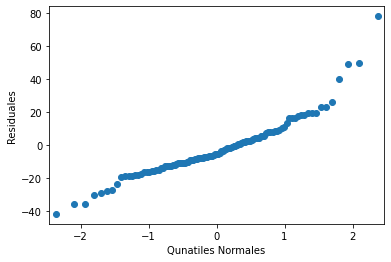

In [46]:
diferencia_ozono_ordenada = diferencia_ozono
diferencia_ozono_ordenada.sort()
fig = sm.qqplot(diferencia_ozono_ordenada)
plt.xlabel('Qunatiles Normales')
plt.ylabel('Residuales')
plt.savefig('./images/Residuales-contra-quantiles-f=punto4.svg')

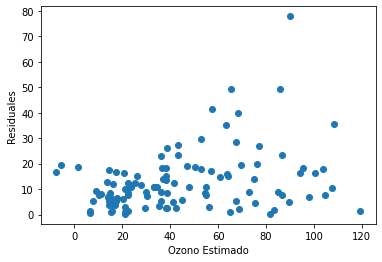

In [68]:

fig = plt.plot(ozono_estimado, diferencia_abs_ozono, 'o')
plt.xlabel('Ozono Estimado')
plt.ylabel('Residuales')
plt.savefig('./images/Residuales-contra-ozono-f=punto4.svg')

In [ ]:
df = pd.read_csv("dataset.csv")
def graficarDatosBrutos(xlabel, ylabel):
    pl.clf()
    pl.scatter(x=df[xlabel], y=df[ylabel])
    pl.savefig(f"./images/{ylabel}-en-funcion-de-{xlabel}.svg")
    pl.clf()
    pl.scatter(x=df[ylabel], y=df[xlabel])
    pl.savefig(f"./images/{xlabel}-en-funcion-de-{ylabel}.svg")

In [ ]:
combinationsOfTwo = list(combinations(VARIABLES, 2))
for par in combinationsOfTwo :
    print(par[0], par[1])
    graficarDatosBrutos(par[0], par[1])
    


In [ ]:
graficarDatosBrutos("radiation", "temperature")

,Unnamed: 0,predicciones
0,0,25.934539
1,1,20.499023
2,2,22.484853
3,3,28.428890
4,4,31.619311
...,...,...
106,106,18.904616
107,107,32.009909
108,108,24.049632
109,109,26.286799


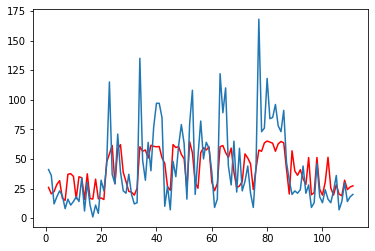

In [ ]:

df_predicciones = pd.read_csv("./Resultados/predicciones_base.csv")
df_independientes = pd.read_csv("dataset.csv")


pl.clf()
pl.plot(df_independientes["X"], df_predicciones["predicciones"], color="red")
pl.plot(df_independientes["X"], df_independientes["ozone"])
df_predicciones

Para hacer:
    Lineal:
    * con f = .4, g(xi) contra g(xi) - yi
    * mismo anterior pero contra |g(xi) -yi| con una curva de g(g(xi)) con f=2/3
    *mismo pero estimado contra variables con curva de g(g(xi)) con f=2/3

    Cuadratica:
    *datos: con f=.8, la sqrt(g(xi),3)
    *